(70, 4)


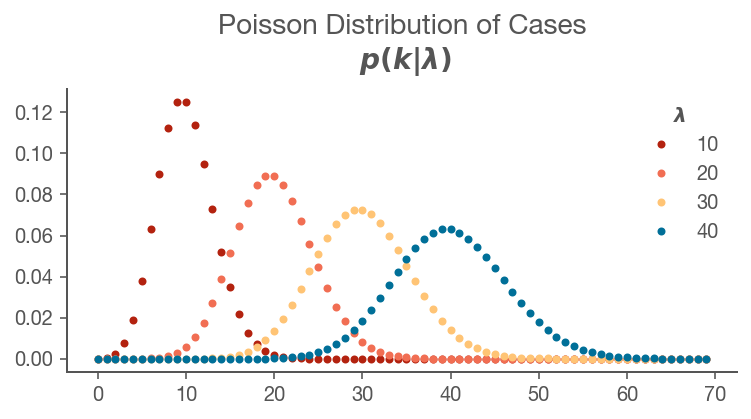

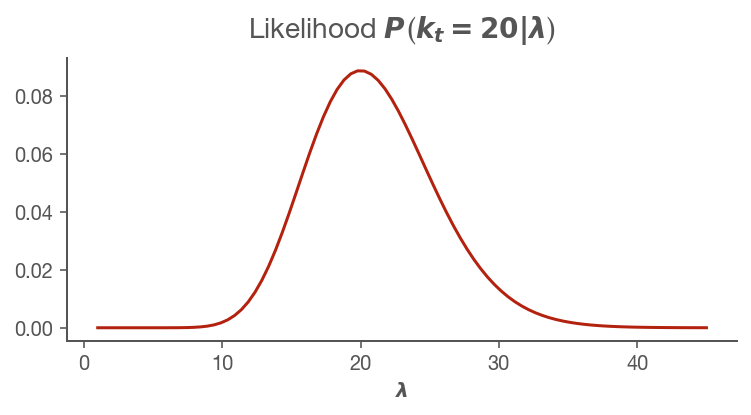

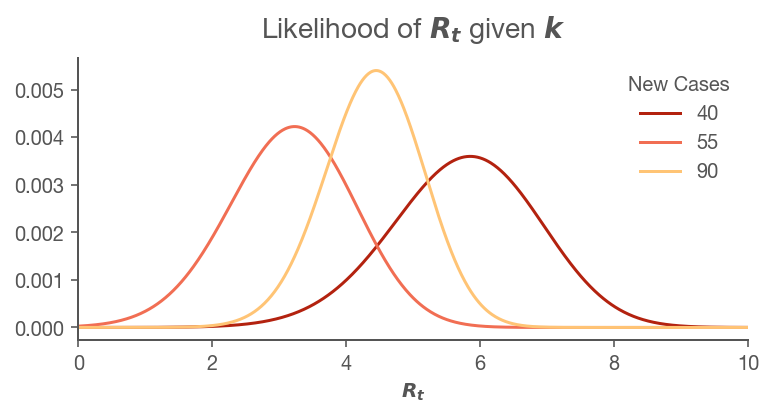

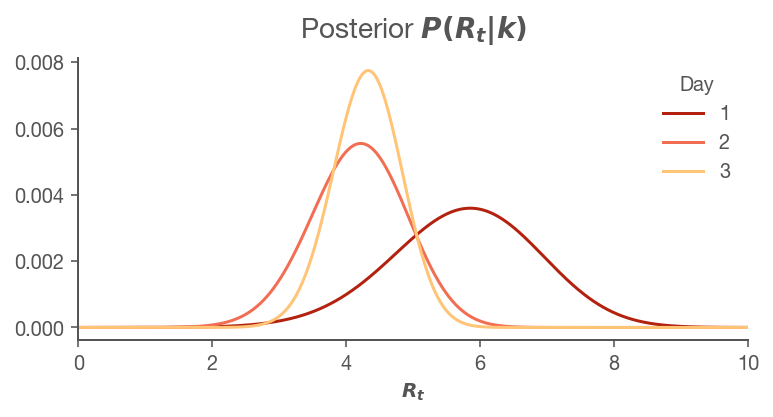

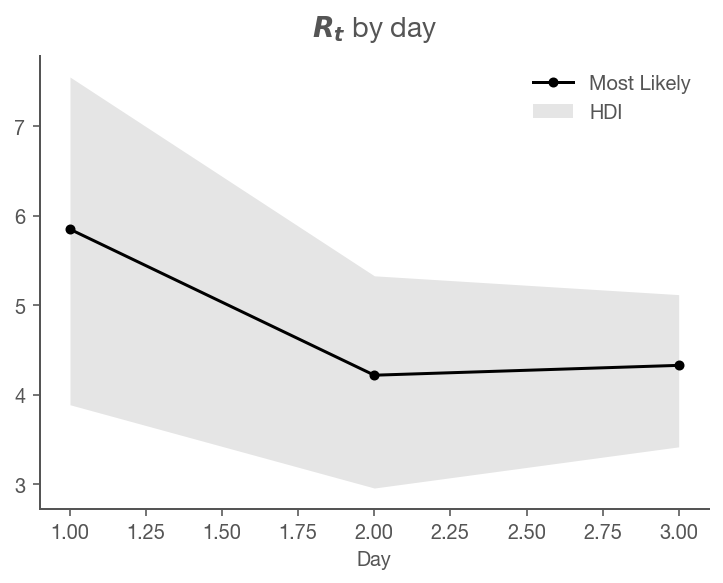

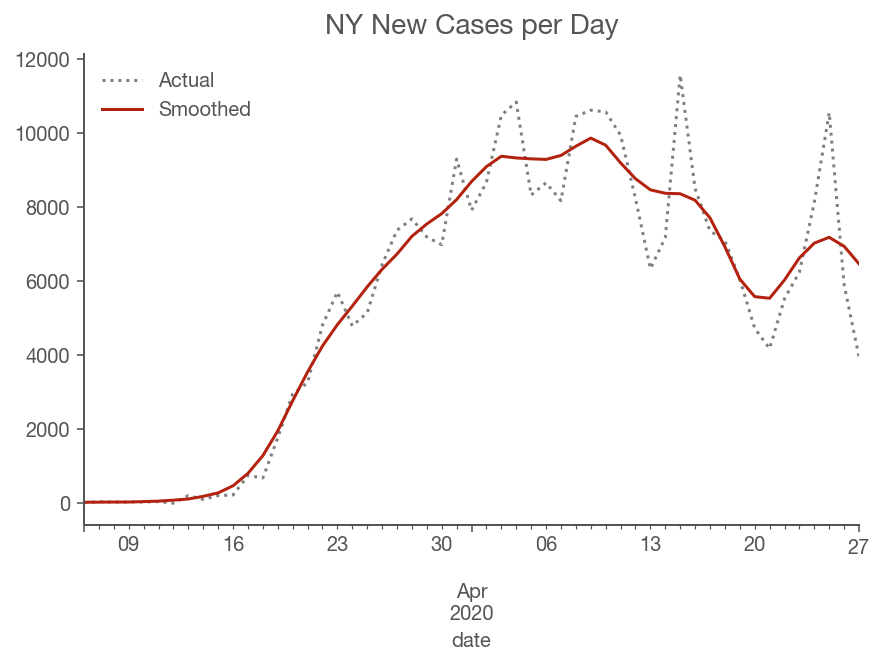

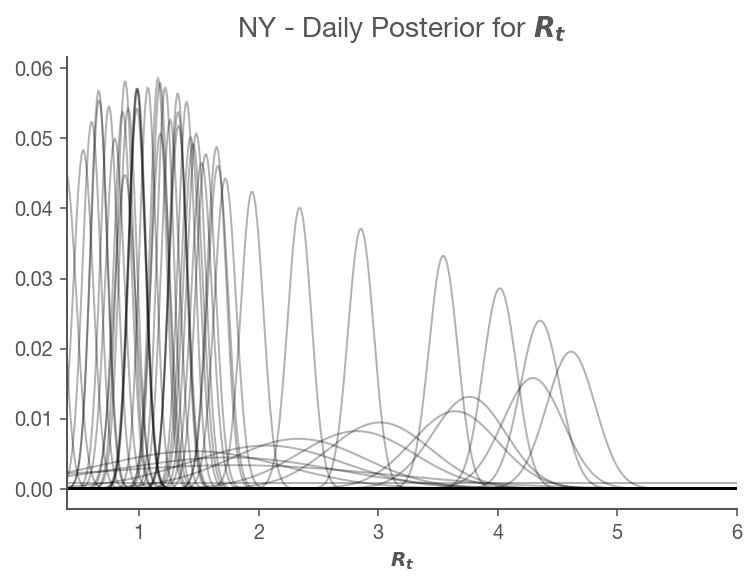

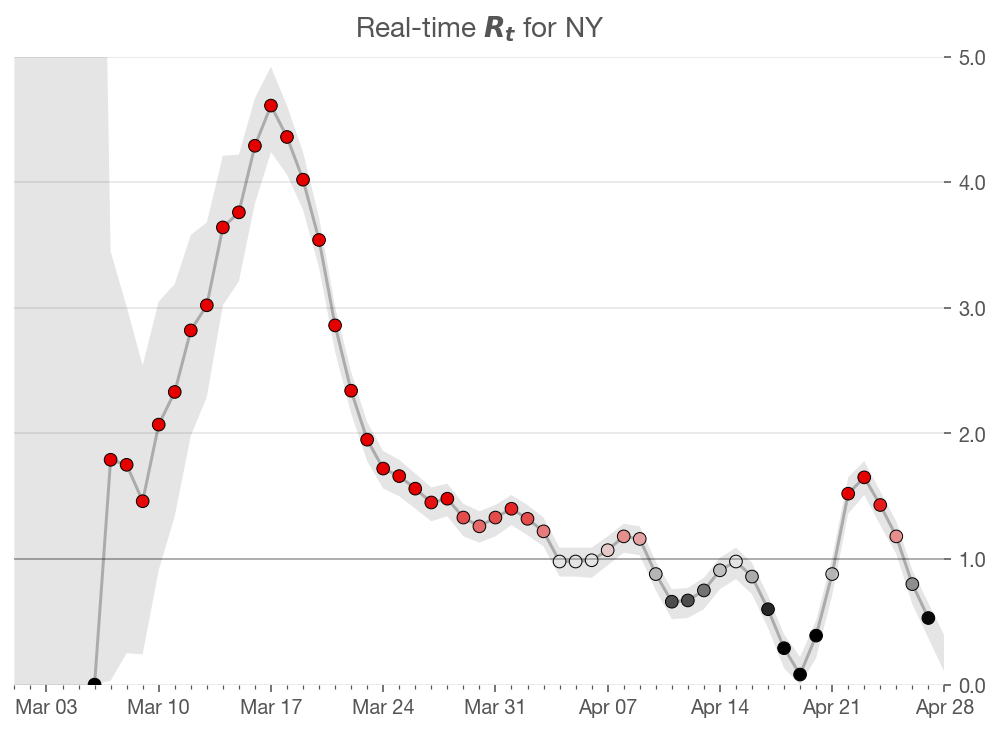

SystemExit: STOP MASTER US NOTEBOOK HERE!

/Users/schalk/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [3]:
%run 'Realtime R0.ipynb'
#import import_ipynb
#import RealtimeR0

## Break the notebook with this to avoid long calculation, only primary functions is required for importing
# raise SystemExit("STOP MASTER US NOTEBOOK HERE!")

In [5]:
import requests
import pandas as pd

#state_name = 'ZA'

### OLD API
## Last complete stats, one day delayed
#url = 'https://api.covid19api.com/total/dayone/country/' + state_name
## Current daily stats, last day might not have updated, if duplicated do not use
##url = 'https://api.covid19api.com/dayone/country/' + state_name

#client = requests.request("GET", url)
#response = client.text
#data_all = pd.read_json(response, orient='columns')
#data_all['Date'] = data_all['Date'].dt.tz_localize(None)
#data_index = data_all.set_index('Date')

## If delayed, manually add last day from another known source
#day = pd.DataFrame({'Confirmed':4220}, index=pd.to_datetime(['2020-04-24']))
#data_index = data_index.append(day)

#country = data_index['Confirmed']
#country

In [90]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv'
states_all = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True).sort_index()
states_all = states_all.rename(columns={'total':'Total RSA'})

# single plot
state_name = 'Total RSA'

# filter data if required
#state_filter = states_all[:-1];
states = states_all
states.tail()

,date,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,Total RSA,source
48,2020-04-24,20200424,480.0,111.0,1281.0,841.0,29.0,24.0,16.0,25.0,1413.0,0.0,4220,https://twitter.com/nicd_sa/status/12537692103...
49,2020-04-25,20200425,488.0,111.0,1304.0,841.0,30.0,23.0,16.0,28.0,1514.0,0.0,4361,https://twitter.com/DrZweliMkhize/status/12541...
50,2020-04-26,20200426,535.0,110.0,1331.0,863.0,31.0,23.0,17.0,28.0,1608.0,0.0,4546,https://twitter.com/DrZweliMkhize/status/12544...
51,2020-04-27,20200427,588.0,111.0,1353.0,902.0,31.0,26.0,17.0,31.0,1737.0,0.0,4793,https://twitter.com/drzwelimkhize/status/12548...
52,2020-04-28,20200428,616.0,113.0,1377.0,919.0,31.0,26.0,17.0,29.0,1870.0,0.0,4996,https://twitter.com/COVID_19_ZA/status/1255200...


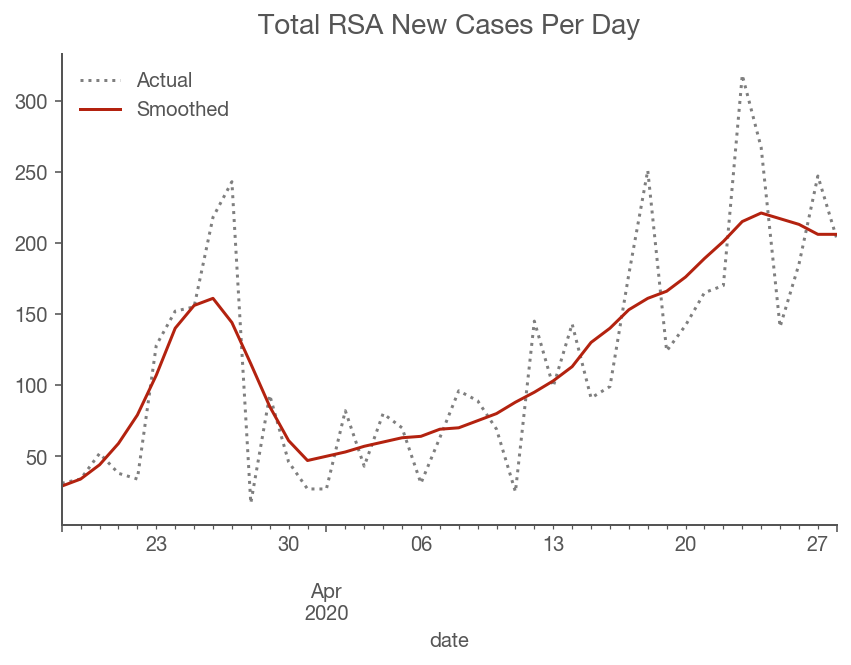

In [91]:
cases = pd.Series(states[state_name].values,index=states['date'])
original, smoothed = prepare_cases(cases)

original.plot(title=f"{state_name} New Cases Per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
             figsize=(500/72, 300/72))

ax = smoothed.plot(label='Smoothed',
                   legend=True)

ax.get_figure().set_facecolor('w')

In [92]:
posteriors, log_likelihood = get_posteriors(smoothed, sigma=.25)

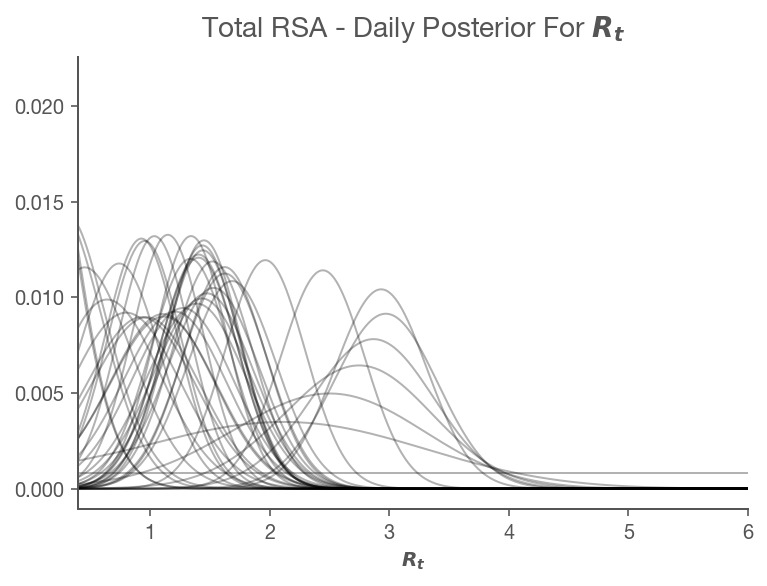

In [93]:
ax = posteriors.plot(title=f'{state_name} - Daily Posterior For $R_t$',
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.4,6))

ax.set_xlabel('$R_t$');

In [95]:
hdis = highest_density_interval(posteriors, p=.9)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
single_result = pd.concat([most_likely, hdis], axis=1)

single_result.tail()

,ML,Low_90,High_90
date,,,
2020-04-24,1.34,0.80,1.80
2020-04-25,1.15,0.63,1.62
2020-04-26,1.04,0.50,1.50
2020-04-27,0.93,0.38,1.39
2020-04-28,0.95,0.40,1.42


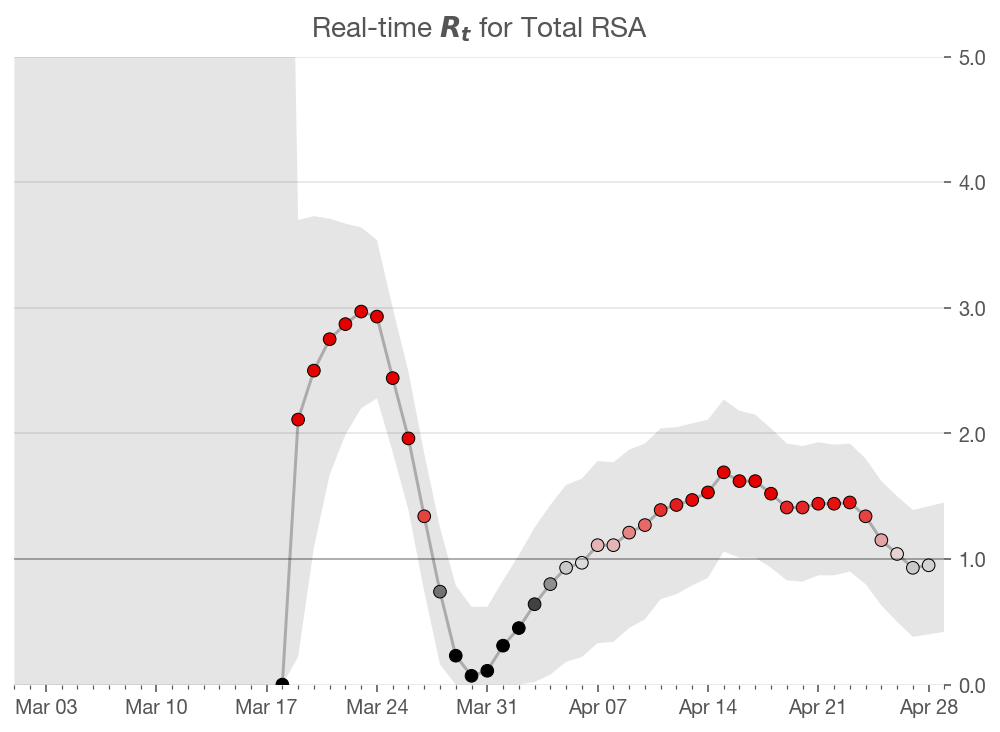

In [96]:
fig, ax = plt.subplots(figsize=(600/72,400/72))

plot_rt(single_result, ax, state_name)
ax.set_title(f'Real-time $R_t$ for {state_name}')
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

In [97]:
np.seterr(divide = 'ignore')

sigmas = np.linspace(1/20, 1, 20)

# only consider the official 9 provinces
states_to_process = list(states.columns.values[2:11])
# states_to_process.append('Total RSA')

results = {}

for state_name in states_to_process:
    
    print(state_name)
    cases = pd.Series(states[state_name].values,index=states['date'])
    new, smoothed = prepare_cases(cases, cutoff=10)
    cut = 10
    
    # Rt for ZA is very small for some provinces
    if len(smoothed) == 0:
        new, smoothed = prepare_cases(cases, cutoff=5)
        cut = 5
        if len(smoothed) == 0:
            new, smoothed = prepare_cases(cases, cutoff=3)
            cut = 3
            ## ignore Rt further for slow growth provinces
            if len(smoothed) == 0:
                print('BREAK')
                clear_output(wait=True)
                continue
            
    print(cut)
    
    result = {}
    
    # Holds all posteriors with every given value of sigma
    result['posteriors'] = []
    
    # Holds the log likelihood across all k for each value of sigma
    result['log_likelihoods'] = []
    
    try:
        for sigma in sigmas:
            posteriors, log_likelihood = get_posteriors(smoothed, sigma=sigma)
            result['posteriors'].append(posteriors)
            result['log_likelihoods'].append(log_likelihood)
    except:
        print('No available sigmas')
    
    # Store all results keyed off of state name
    results[state_name] = result
    clear_output(wait=True)

print('Done')

Done


EC
FS
GP
KZN
WC


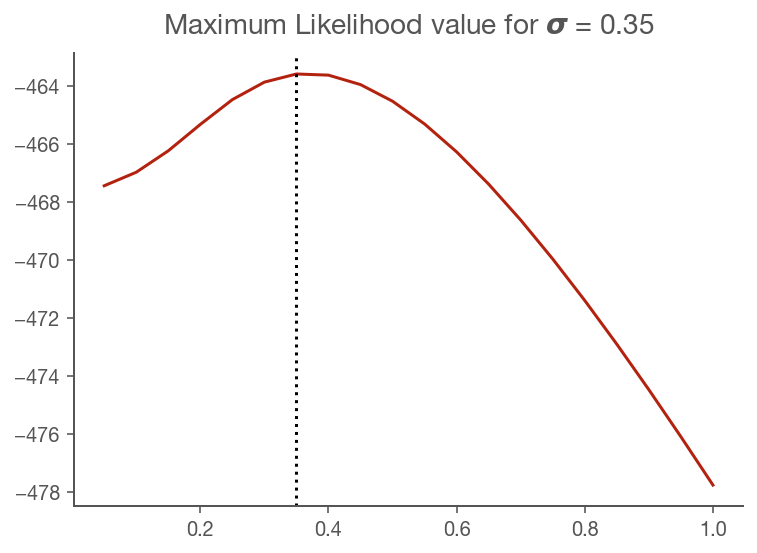

In [98]:
# Each index of this array holds the total of the log likelihoods for
# the corresponding index of the sigmas array.
total_log_likelihoods = np.zeros_like(sigmas)

# Loop through each state's results and add the log likelihoods to the running total.
for state_name, result in results.items():
    print(state_name)
    total_log_likelihoods += result['log_likelihoods']

# Select the index with the largest log likelihood total
max_likelihood_index = total_log_likelihoods.argmax()

# Select the value that has the highest log likelihood
sigma = sigmas[max_likelihood_index]

# Plot it
fig, ax = plt.subplots()
ax.set_title(f"Maximum Likelihood value for $\sigma$ = {sigma:.2f}");
ax.plot(sigmas, total_log_likelihoods)
ax.axvline(sigma, color='k', linestyle=":")

In [99]:
final_results = None

for state_name, result in results.items():
    print(state_name)
    posteriors = result['posteriors'][max_likelihood_index]
    hdis_90 = highest_density_interval(posteriors, p=.9)
    hdis_50 = highest_density_interval(posteriors, p=.5)
    most_likely = posteriors.idxmax().rename('ML')
    result = pd.concat([most_likely, hdis_90, hdis_50], axis=1)
    
    # add province index for SA data
    result.index = pd.MultiIndex.from_product([[state_name], result.index], names=['state','date'])
    
    if final_results is None:
        final_results = result
    else:
        final_results = pd.concat([final_results, result])
    clear_output(wait=True)

print('Done.')
final_results

Done.


ML  Low_90  High_90  Low_50  High_50
state date                                              
EC    2020-04-10  0.00    0.00    10.81    0.00     6.01
      2020-04-11  3.84    0.77     6.33    2.53     4.90
      2020-04-12  3.35    1.21     5.12    2.43     4.04
      2020-04-13  3.11    1.51     4.55    2.38     3.63
      2020-04-14  2.67    1.30     3.87    2.11     3.16
...                ...     ...      ...     ...      ...
WC    2020-04-24  1.68    0.97     2.33    1.35     1.91
      2020-04-25  1.41    0.68     2.03    1.12     1.67
      2020-04-26  1.21    0.52     1.86    0.85     1.41
      2020-04-27  0.99    0.27     1.61    0.65     1.21
      2020-04-28  1.06    0.33     1.69    0.70     1.27

[181 rows x 5 columns]

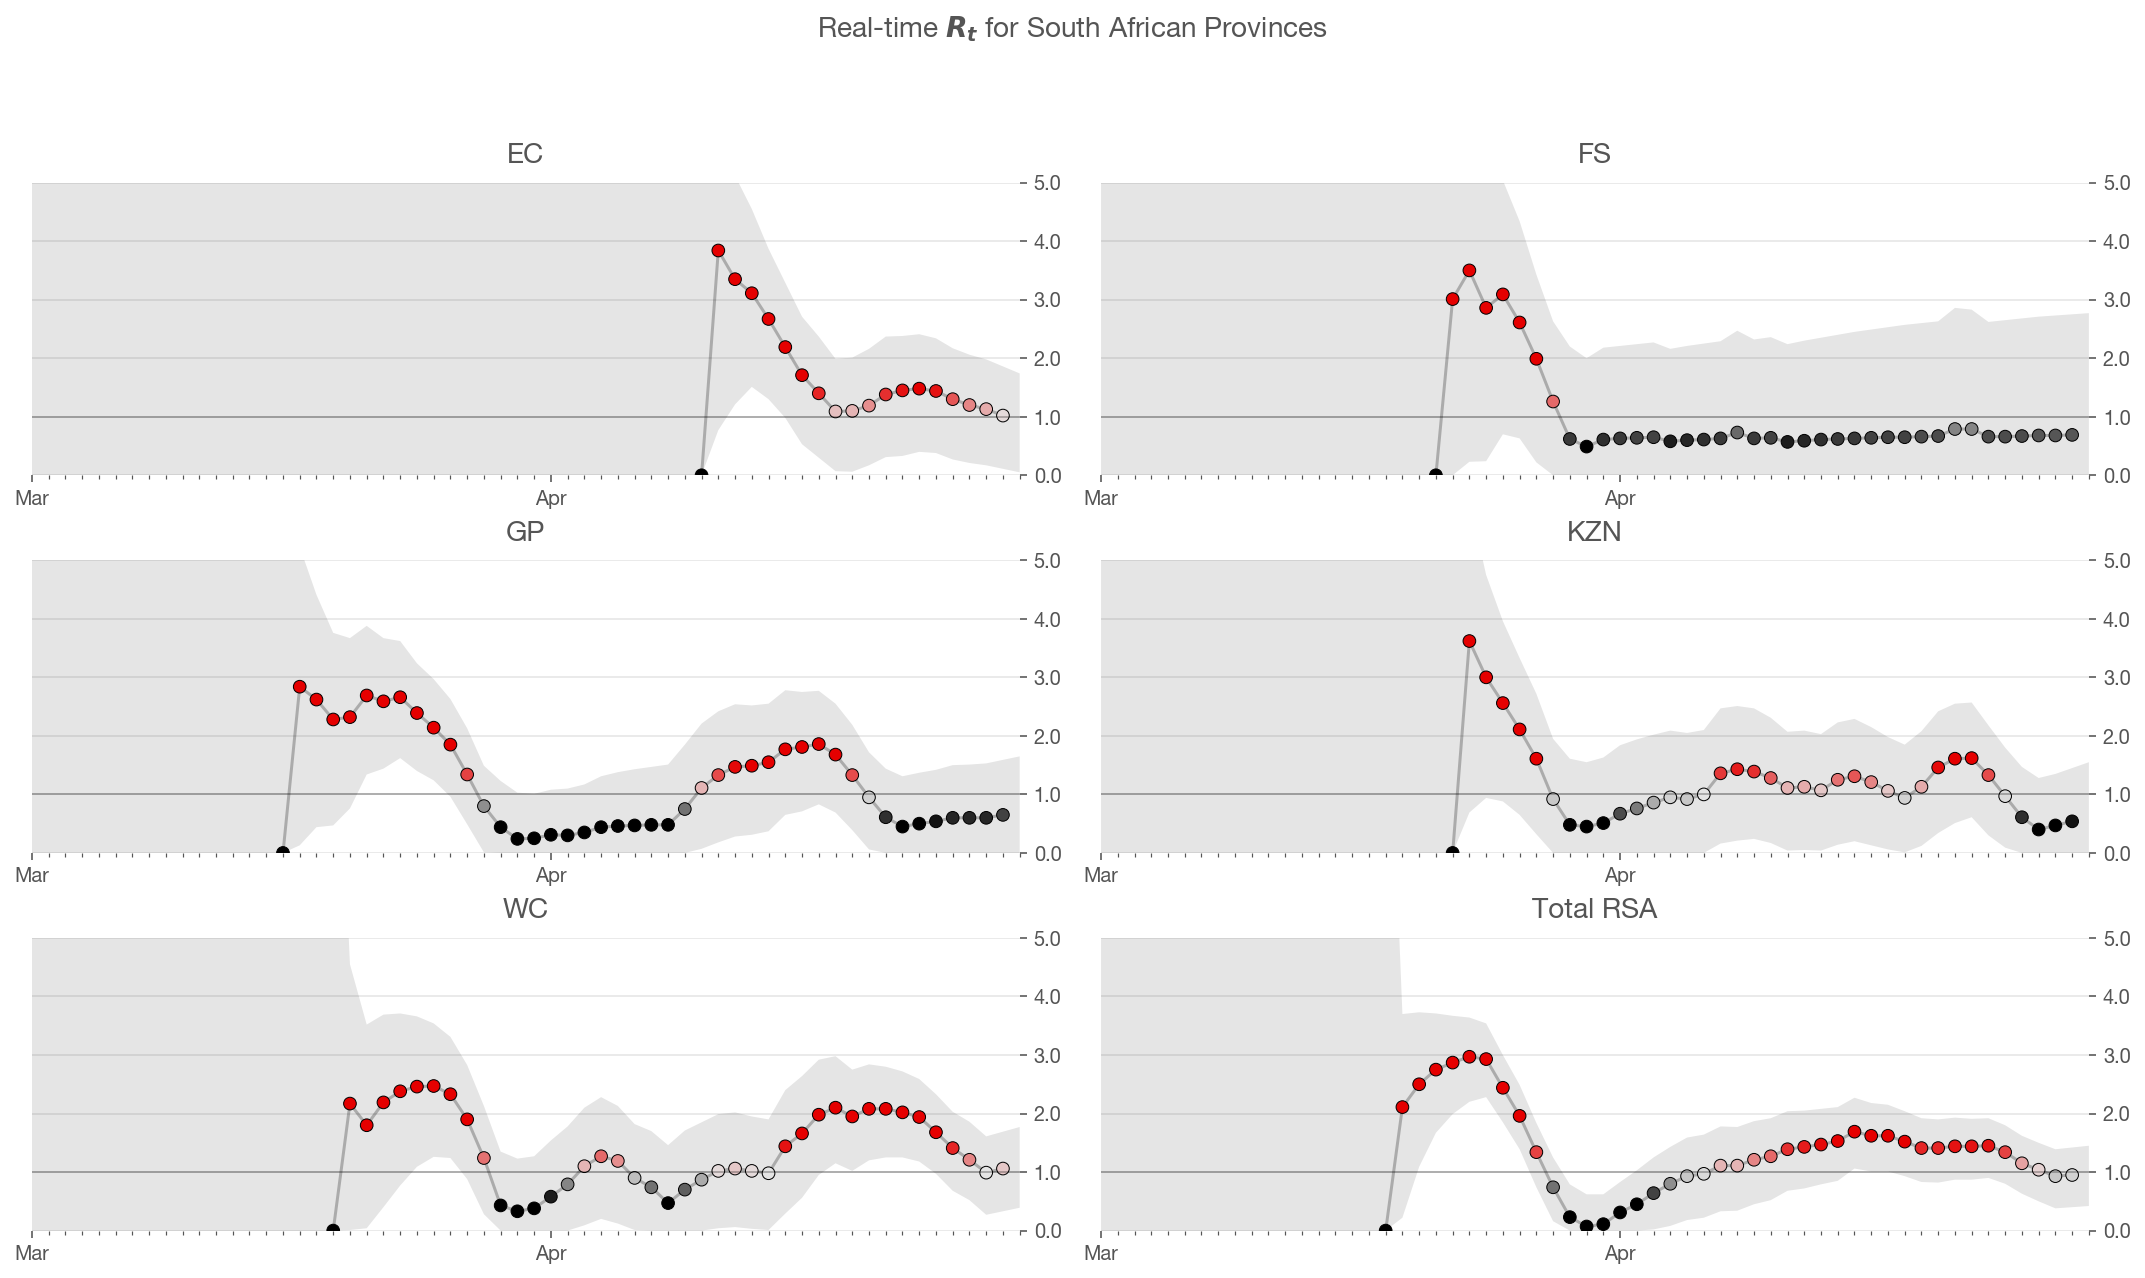

In [101]:
ncols = 2
nrows = int(np.ceil(len(results) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (state_name, result) in enumerate(final_results.groupby('state')):
    plot_rt(result, axes.flat[i], state_name)
plot_rt(single_result, axes.flat[i+1], 'Total RSA')
    
fig.tight_layout()
fig.suptitle(f'Real-time $R_t$ for South African Provinces', fontsize=14)
fig.subplots_adjust(top=0.85)
fig.set_facecolor('w')

In [102]:
# South Arica data as of 2020/04/28
no_lockdown = [

]
partial_lockdown = [

]

FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]

In [103]:
mr = final_results.groupby(level=0)[['ML', 'High_90', 'Low_90']].last()
mr

,ML,High_90,Low_90
state,,,
EC,1.02,1.86,0.11
FS,0.69,2.75,0.00
GP,0.65,1.59,0.00
KZN,0.54,1.45,0.00
WC,1.06,1.69,0.33


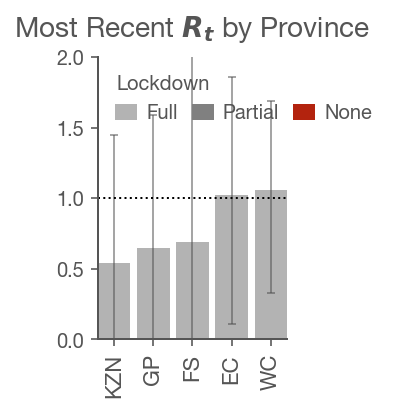

In [106]:
mr.sort_values('ML', inplace=True)
plot_standings(mr, title='Most Recent $R_t$ by Province');

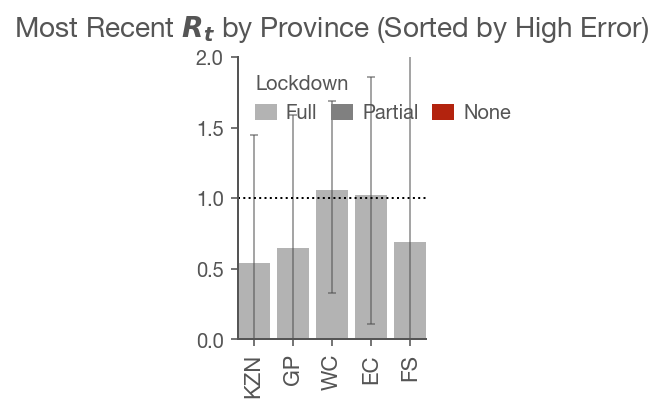

In [107]:
mr.sort_values('High_90', inplace=True)
plot_standings(mr, title='Most Recent $R_t$ by Province (Sorted by High Error)');

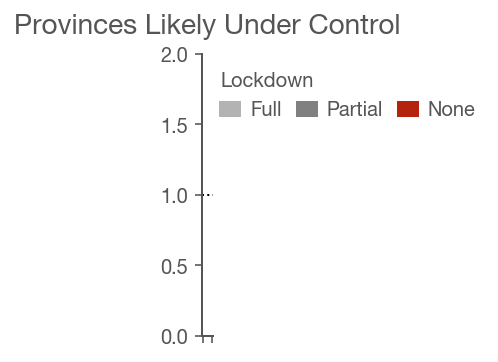

In [108]:
show = mr[mr.High_90.le(1.1)].sort_values('ML')
fig, ax = plot_standings(show, title='Provinces Likely Under Control');

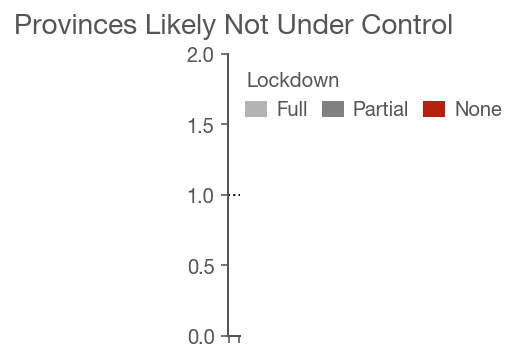

In [73]:
show = mr[mr.Low_90.ge(1.05)].sort_values('Low_90')
fig, ax = plot_standings(show, title='Provinces Likely Not Under Control');